In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv

# Supress Warnings
warnings.filterwarnings('ignore')

from random import randrange
from sklearn import preprocessing, tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, precision_score,
                             recall_score, f1_score)

import os
for dirname, _, filenames in os.walk('/Users/vinh/Desktop/Python/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/Users/vinh/Desktop/Python/data/.DS_Store
/Users/vinh/Desktop/Python/data/letters_CG.csv
/Users/vinh/Desktop/Python/data/spam_email.csv


In [4]:
data_email = pd.read_csv('./data/spam_email.csv')
data_email.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,semicol,paren,bracket,bang,dollar,pound,cap_avg,cap_long,cap_total,Class
0,0.00,0.00,0.29,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.178,0.0,0.044,0.000,0.00,1.666,10,180,ham
1,0.46,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.125,0.0,0.000,0.000,0.00,1.510,10,74,ham
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.000,0.000,0.00,1.718,11,55,ham
3,0.33,0.44,0.37,0.0,0.14,0.11,0.00,0.07,0.97,1.16,...,0.006,0.159,0.0,0.069,0.221,0.11,3.426,72,819,spam
4,0.00,2.08,0.00,0.0,3.12,0.00,1.04,0.00,0.00,0.00,...,0.000,0.000,0.0,0.263,0.000,0.00,1.428,4,20,spam


In [5]:
X = data_email.drop('Class', axis = 1)

y = data_email.Class

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)

# Standardize the x_train and x_test datasets
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)


In [7]:
# Change predictions from {ham,spam} to {-1,1} in order to properly compute predictions
y_test_new = np.where(y_test == 'ham', -1, 1)
y_train_new = np.where(y_train == 'ham', -1, 1)

# Class for AdaBoost implementation
class AdaBoostCLF:

    def __init__(self, X_train, y_train, T):
        self.x_train = X_train
        self.y_train = list(np.array(y_train).flatten())
        self.T = T
        self.N = len(self.x_train)
        self.weights =  np.ones(self.N)/self.N
        self.stumps = []  
        self.alphas = []

    def train(self):
        for t in range(self.T):
            dtc =  DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 1)
            stump = dtc.fit(self.x_train, self.y_train, sample_weight = self.weights)
            pred_train = dtc.predict(self.x_train)
            
            # Compute misclassified instances, errors, and alphas
            incorrect = np.where(pred_train != self.y_train, 1, 0)
            error = np.dot(self.weights, incorrect )/(self.weights).sum(dtype = 'float')
            alpha_t = 0.5 * np.log((1 - error) / error)
            
            # Compute the corresponding pos/neg coeffs to allow for proper weight updates
            weight_coeffs =  np.where(incorrect == 1 , 1, -1)
            weights = np.multiply(self.weights, np.exp(alpha_t * weight_coeffs))
            norm_weights = (weights/weights.sum(dtype = 'float'))
            
            # Update weights, stumps, and betas for current t iteration 
            self.weights = norm_weights
            self.stumps.append(stump)
            self.alphas.append(alpha_t)
            
    def computePredictions(self, X):
            num_classifiers = self.T
            num_records = len(X)
            
            # Initialize a list to hold the prediction* the corresponding alpha_t weights a*h(x) for each iteration
            alpha_preds = np.zeros((num_records, num_classifiers))
            
            # Iterate through all classifiers and all given records and add prediction 
            for c in range(num_classifiers):
                curr_clf = self.stumps[c] 
                curr_preds = curr_clf.predict(X)
                for i in range(num_records):
                    alpha_preds[i][c] = curr_preds[i] * self.alphas[c]
            final_preds = []
            
            # Iterate through each record to compute hypothesis across all T classifiers
            for tr in range(num_records):
                if np.sign(sum(alpha_preds[tr])) <= 0:
                    final_preds.append(-1)
                else:
                    final_preds.append(1)
            return final_preds

In [8]:
# Initialize different iteration values to try for T
T_values = [1, 50, 100, 150]

# Initialize lists to hold training and testing scores
train_scores = []
test_scores = []

# Function to compute all scores itertatively across various T iterations
def computeScores(X_train, y_train, X_test, y_test, T_values):
    for i in range(0, len(T_values)):
        clf = AdaBoostCLF(X_train, y_train, T_values[i])
        clf.train()
        preds_train = clf.computePredictions(X_train)
        preds_test = clf.computePredictions(X_test)
        acc_score_tr = accuracy_score(y_train,preds_train)
        acc_score_tst = accuracy_score(y_test, preds_test)
        err_score_tr = 1 - acc_score_tr
        err_score_tst = 1 - acc_score_tst
        precision_tr =  precision_score(y_train, preds_train, pos_label = 1)
        precision_tst =  precision_score(y_test, preds_test, pos_label = 1)
        recall_tr =  recall_score(y_train, preds_train, pos_label = 1)
        recall_tst =  recall_score(y_test, preds_test, pos_label = 1)
        train_scores.extend(("", acc_score_tr, err_score_tr, precision_tr, recall_tr))
        test_scores.extend(("", acc_score_tst, err_score_tst, precision_tst, recall_tst))

# Call the function to compute scores and populate lists
computeScores(X_train_scaled, y_train_new, X_test_scaled, y_test_new, T_values)

# Create dictionary of test/train metrics
scores_dict = {'training' :train_scores, 'testing' : test_scores } 

# Convert all scores to dataframe
scoresDF = pd.DataFrame.from_dict(scores_dict)
row_names = ['1 decision stump', 'accuracy:', 'error:', 'precision:','recall:',
             '50 decision stumps', 'accuracy:', 'error:', 'precision:','recall:',
            '100 decision stumps', 'accuracy:', 'error:', 'precision:','recall:',
            '150 decision stumps', 'accuracy:', 'error:', 'precision:','recall:']

scoresDF.index = row_names
scoresDF

,training,testing
1 decision stump,,
accuracy:,0.791667,0.790331
error:,0.208333,0.209669
precision:,0.731164,0.703655
recall:,0.765919,0.772206
50 decision stumps,,
accuracy:,0.93587,0.929386
error:,0.06413,0.070614
precision:,0.932657,0.909222
recall:,0.906726,0.904011


In [9]:
train_error = [train_scores[2], train_scores[7], train_scores[12], train_scores[17]]
test_error = [test_scores[2], test_scores[7], test_scores[12], test_scores[17]]

train_precision = [train_scores[3], train_scores[8], train_scores[13], train_scores[18]]
test_precision = [test_scores[3], test_scores[8], test_scores[13], test_scores[18]]

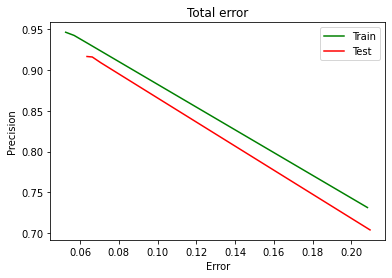

In [10]:
plt.plot(train_error, train_precision, 'g-', label='Train')
plt.plot(test_error, test_precision, 'r-', label='Test')
plt.title('Total error')
plt.xlabel('Error')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()